## Dragon Real Estate - Price Predictor

In [2]:
import pandas as pd
import numpy as np

In [4]:
housing = pd.read_csv("./data.csv")

In [48]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [49]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         501 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [50]:
housing.columns[housing.isna().any()].tolist()   ## Getting columns with missing values

#There are null values in RM i.e average number of rooms. 

['RM']

In [51]:
housing.RM.fillna(housing.RM.mode()[0], inplace=True) # We will use the most frequent observation to fill the missing values

In [52]:
housing['CHAS'].value_counts()

# CHAS is very unbalanced. We need to make sure that training and testing data, both contains 1

0    471
1     35
Name: CHAS, dtype: int64

In [53]:
housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.278696,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.704360,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.877250,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.194000,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.618750,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Train-Test Splitting

In [54]:
# we will use stratified Shuffle Split to properly split CHAS

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['CHAS']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [55]:
strat_train_set['CHAS'].value_counts()

0    376
1     28
Name: CHAS, dtype: int64

In [56]:
strat_test_set['CHAS'].value_counts()

0    95
1     7
Name: CHAS, dtype: int64

In [57]:
training_data = strat_train_set.copy()

## Looking for Correlations

In [58]:
# We will check the correlation of MEDV (our target) with other columns
corr_matrix = training_data.corr()
corr_matrix['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.680272
B          0.361761
ZN         0.339741
DIS        0.240451
CHAS       0.205066
AGE       -0.364596
RAD       -0.374693
CRIM      -0.393715
NOX       -0.422873
TAX       -0.456657
INDUS     -0.473516
PTRATIO   -0.493534
LSTAT     -0.740494
Name: MEDV, dtype: float64

* There is strong positive correlation of RM with MEDV, and good negative correlation with LSTAT
* There is some negative correlation of NOX, TAX, INDUS, PTRATIO

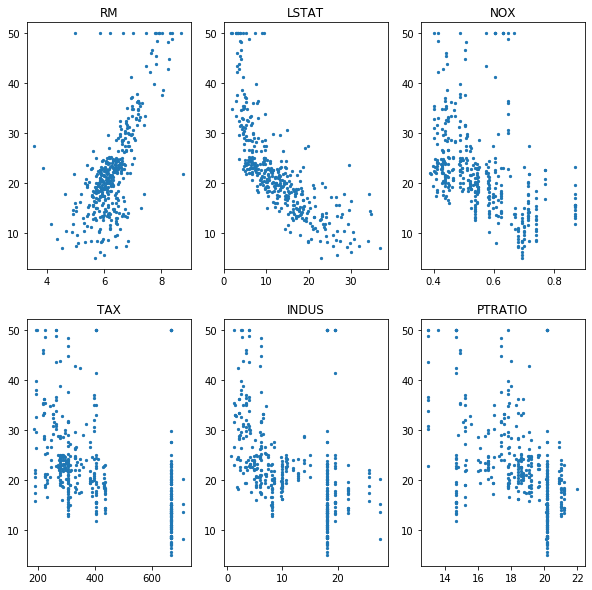

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,axes =  plt.subplots(2,3, figsize=(10,10))
x = np.arange(1,5)
axes[0][0].scatter(training_data['RM'],training_data['MEDV'], s=5)
axes[0][0].set_title('RM')
#there are outliers in RM. we need to get rid of them.

axes[0][1].scatter(training_data['LSTAT'],training_data['MEDV'], s=5)
axes[0][1].set_title('LSTAT')
axes[0][2].scatter(training_data['NOX'],training_data['MEDV'], s=5)
axes[0][2].set_title('NOX')
axes[1][0].scatter(training_data['TAX'],training_data['MEDV'], s=5)
axes[1][0].title.set_text('TAX')
axes[1][1].scatter(training_data['INDUS'],training_data['MEDV'], s=5)
axes[1][1].title.set_text('INDUS')
axes[1][2].scatter(training_data['PTRATIO'],training_data['MEDV'], s=5)
axes[1][2].title.set_text('PTRATIO')

In [60]:
outlier_index = training_data[(training_data.RM<7) & (training_data.MEDV>49)].index.to_list()
outlier_index.extend(training_data[(training_data.RM<4) & (training_data.MEDV>20)].index.to_list())
training_data.drop(labels=outlier_index, inplace=True)

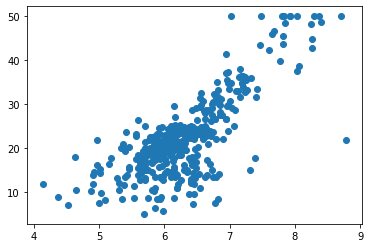

In [61]:
plt.scatter(x=training_data['RM'], y=training_data['MEDV'])
#outliers have been removed from RM.

## Creating a Pipeline

In [62]:
#This is a preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
lr= LinearRegression()
from sklearn.tree import DecisionTreeRegressor
dt= DecisionTreeRegressor()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42)

In [63]:
trainX = training_data.drop(columns=['MEDV'])
trainY = training_data['MEDV']

testX = strat_test_set.drop(columns=['MEDV'])
testY = strat_test_set.MEDV

models = {"Linear Regression":lr, "Decision tree": dt, "random forest": rf}

for name, model in models.items():
    my_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                          ('std_scaler', StandardScaler()),
                          (name, model)])
    my_pipeline.fit(trainX, trainY)
    print("accuracy of ", name,":- ", my_pipeline.score(testX, testY))

accuracy of  Linear Regression :-  0.7557248554336593
accuracy of  Decision tree :-  0.8392328617569308
accuracy of  random forest :-  0.857248880117231


In [64]:
# since we are getting max accuracy from random forest, we will use that model
my_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                          ('std_scaler', StandardScaler()),
                          ("Random Forest", rf)])
my_pipeline.fit(trainX, trainY)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('std_scaler', StandardScaler()),
                ('Random Forest',
                 RandomForestRegressor(n_jobs=2, random_state=42))])

## testing prediction with a sample

In [65]:
sample_data = testX[100:101] #taking one row from test data
print("Predicting with an accuracy of ", np.round(my_pipeline.score(testX, testY),2), "%")
print("Price of house would be ", my_pipeline.predict(sample_data)[0], "million")

Predicting with an accuracy of  0.86 %
Price of house would be  21.53600000000001 million
